<a href="https://colab.research.google.com/github/TorbjornLarsson/SMI/blob/main/preparatory_notebooks/F4_lda_qda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook: F4 -- LDA, QDA

*Authors*: Amir Baghi, Daniel Gedon<br>
*Date*: 31.10.2023<br>
*Updated*: 18.01.2024

This notebook is complementary to lecture F4 about LDA/QDA in order to highlight its key concepts. The focus will be on
1. Visualizing **multivariate Gaussian distributions**
2. **LDA**: Fitting Gaussian with the same covariance to data
3. **QDA**: Fitting Gaussian with varying covariance to data

Please read the instructions and play around with the notebook where it is described.

In [35]:
pip install -q ipywidgets

In [36]:
# imports necessary libraries
%matplotlib inline

import scipy.stats
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, widgets

np.random.seed(42) # fix the random seed

---

## 1. Multivariate Gaussians

A multivariate gaussian distribution for $k$ dimensions is given by the following probability density function (PDF):

$f(x) = \mathcal{N}(x; \mu, \Sigma) = \frac{1}{\sqrt{(2 \pi)^k \det \Sigma}}\exp\left( -\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu) \right)$

with $\Sigma$ as the covariance matrix and $\mu$ as the mean vector.
Here, we will investigate how such PDFs look and what the influence of $\mu$, $\Sigma$ is.

Below are helper functions to plot the results. Skip over those and go to the next text box.

In [37]:
def plot_multivariate_gaussian(mu,Sigma,elevation=0, azimuth=90):
    N = 100
    X = np.linspace(-5, 5, N)
    Y = np.linspace(-5, 5, N)
    X, Y = np.meshgrid(X, Y)

    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    Z = scipy.stats.multivariate_normal.pdf(pos, mu, Sigma)

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                    cmap=cm.viridis)
    cset = ax.contourf(X, Y, Z, zdir='z', offset=-0.15, cmap=cm.viridis)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Multivariate Gaussians')

    ax.set_zlim(-0.15,0.1)
    ax.set_zticks(np.linspace(0,0.1,5))
    ax.view_init(elev=elevation,azim=azimuth)

    plt.show()

def plot_multivariate_gaussian_interactive(mu,Sigma, initial_elevation=90, initial_azimuth=0):
    assert mu.shape == (2,), 'mu must be of shape (2,)'
    assert Sigma.shape == (2,2), 'Sigma must be of shape (2,2)'
    assert np.allclose(Sigma, Sigma.T), 'Sigma must be symmetric'
    assert np.all(np.linalg.eigvals(Sigma) > 0), 'Sigma must be positive definite'

    interact(plot_multivariate_gaussian,
             mu=widgets.fixed(mu),
             Sigma=widgets.fixed(Sigma),
             elevation=widgets.FloatSlider(min=0, max=90, step=1, value=initial_elevation),
             azimuth=widgets.FloatSlider(min=0, max=360, step=1, value=initial_azimuth)
             )


Below, we plot a multivariate Gaussian for a specific mean vector $\mu$ and covariance matrix $\Sigma$. We visualize both, the PDF and a contour plot below.

Tasks:
1. Change the elevation/azimuth using the sliders to familiarize yourself with the PDF and contour plot. Note: You first have to run all code cells until here to change the view.
2. Understand the effect of the mean vector $\mu$: change $\texttt{mu}$ and observe the change in the PDF
3. Understand the effect of the covariance matrix $\Sigma$: change $\texttt{Sigma}$ and observe the change. Some ideas:
- What happens with a diagonal $\Sigma$?
- What happens if $\Sigma_{11}>\Sigma_{22}$ or vice versa?
- What happens when you add/remove off diagonal values? Note $\Sigma$ has to be symmetric $\Sigma_{12}=\Sigma_{21}$.

In [38]:
# mean mu is a vector of size 2
mu = np.array([0., 0.])
# covariance Sigma is a matrix of size 2x2
Sigma = np.array([[1. , 0.5],
                  [0.5 , 1.]])

# plot the multivariate gaussian
plot_multivariate_gaussian_interactive(
    mu,Sigma,
    initial_elevation=90, initial_azimuth=90,
    )

interactive(children=(FloatSlider(value=90.0, description='elevation', max=90.0, step=1.0), FloatSlider(value=…



---


## 2. Linear discriminant analysis (LDA)

In linear discriminant analysis we fit $m$ Gaussians with the same covariance matrix to data with $m$ classes. Here we focus on $m=2$, the binary case.

Below is a helper function to plot the results. Skip over it and go to the next text box.

In [39]:
def plot_lda(Sigma=None):
    N = 150
    limit = 4.5
    X = np.linspace(-limit, limit, N)
    Y = np.linspace(-limit, limit, N)
    X, Y = np.meshgrid(X, Y)

    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    pi = np.array([0.5, 0.5])
    mu_true = np.array([[-1., -1.],
                        [1., 1.]])
    Sigma_true = np.array([[[ 1. , -0.7], [-0.7,  1.]],
                           [[ 1. ,  0.8], [ 0.8,  1.3]]])


    fig = plt.figure()
    ax = fig.add_subplot()
    if Sigma is not None:
        assert Sigma.shape == (2,2), 'Sigma must be of shape (2,2)'
        assert np.allclose(Sigma, Sigma.T), 'Sigma must be symmetric'
        assert np.all(np.linalg.eigvals(Sigma) > 0), 'Sigma must be positive definite'
        Z = pi[0]*scipy.stats.multivariate_normal.pdf(pos, mu_true[0], Sigma) + \
            pi[1]*scipy.stats.multivariate_normal.pdf(pos, mu_true[1], Sigma)
        cset = ax.contourf(X, Y, Z, cmap=cm.viridis)

    s1 = scipy.stats.multivariate_normal.rvs(mu_true[0], Sigma_true[0], int(0.6*N), random_state=42)
    s2 = scipy.stats.multivariate_normal.rvs(mu_true[1], Sigma_true[1], int(0.4*N), random_state=42)

    ax.scatter(s1[:, 0], s1[:, 1], marker='x', color='red')
    ax.scatter(s2[:, 0], s2[:, 1], marker='o', facecolors='none', edgecolors='blue')

    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Linear discriminant analysis')
    ax.set_aspect('equal')

Below we have some data for two classes: red 'x' and blue 'o' represent each class. Tasks:
1. View the data by running the code cell below
2. Comment line 5 and run the cell with line 8 instead. You will see that two Gaussians with the same covariance specified by $\texttt{Sigma}$ are fit to the two data clusters.
3. Try to modify $\texttt{Sigma}$ such that the Gaussians fit the data as good as possible.

LDA will use the two Gaussians and then add a **linear** decision boundary between the two fitted Gaussians to classify the data.

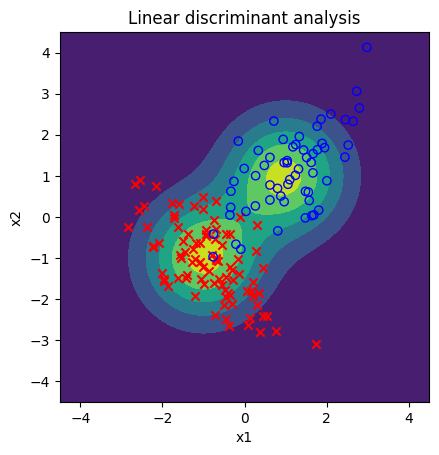

In [40]:
Sigma = np.array([[1., 0.],
                  [0., 1.]])

# First: plot the data with the following line to visualize it
# plot_lda(Sigma=None)

# Second: comment the line above and replace with the one below to fit your Sigma
plot_lda(Sigma=Sigma)

---

## 3. Quadratic discriminant analysis (QDA)


In quadratic discriminant analysis we extend LDA such that we use Gaussians with different covariance matrices $\Sigma$.

Below is a helper function to plot the results. Skip over it and go to the next text box.

In [41]:
def plot_qda(mu, Sigma):
    assert mu.shape == (2,), 'mu must be of shape (2,)'
    assert Sigma.shape == (2,2), 'Sigma must be of shape (2,2)'
    assert np.allclose(Sigma, Sigma.T), 'Sigma must be symmetric'
    assert np.all(np.linalg.eigvals(Sigma) > 0), 'Sigma must be positive definite'

    N = 150
    limit = 4.5
    X = np.linspace(-limit, limit, N)
    Y = np.linspace(-limit, limit, N)
    X, Y = np.meshgrid(X, Y)

    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    pi = np.array([0.5, 0.5])
    mu_true = np.array([[-1., -1.],
                        [1., 1.]])
    Sigma_true = np.array([[[ 1. , -0.7], [-0.7,  1.]],
                           [[ 1. ,  0.8], [ 0.8,  1.3]]])


    Z = pi[0]*scipy.stats.multivariate_normal.pdf(pos, mu, Sigma) + \
        pi[1]*scipy.stats.multivariate_normal.pdf(pos, mu_true[1], Sigma_true[1])

    fig = plt.figure()
    ax = fig.add_subplot()
    cset = ax.contourf(X, Y, Z, cmap=cm.viridis)

    s1 = scipy.stats.multivariate_normal.rvs(mu_true[0], Sigma_true[0], int(0.6*N), random_state=42)
    s2 = scipy.stats.multivariate_normal.rvs(mu_true[1], Sigma_true[1], int(0.4*N), random_state=42)

    ax.scatter(s1[:, 0], s1[:, 1], marker='x', color='red')
    ax.scatter(s2[:, 0], s2[:, 1], marker='o', facecolors='none', edgecolors='blue')

    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Linear discriminant analysis')
    ax.set_aspect('equal')

We use the same data as for LDA above. Now the Gaussian for the blue class is well fit already. Your task:
1. Change the mean $\texttt{mu}$ to place the second Gaussian well for the red class.
2. Change the covariance $\texttt{Sigma}$ such that the second gaussian fits the red class well.

QDA will use the two Gaussians and then add a **quadratic** decision boundary between the two fitted Gaussians to classify the data. It is therefore more flexible than LDA.

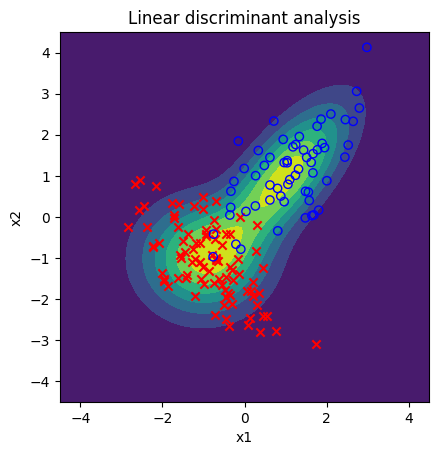

In [43]:
mu = np.array([-1., -1.])
Sigma = np.array([[1., 0.],
                  [0., 0.8]])


plot_qda(mu, Sigma)

---

# Take-home message

* Multivariate Gaussians are determined by the mean vector and a symmetric, positive-definite covariance matrix.
* Understand how the mean vector and covariance matrix influene the shapre of the Gaussian
* LDA fits a Gaussian with the same covariance to each class to the data.
* QDA fits a separate Gaussian (with different covariance) for each class to the data.
* Both, LDA and QDA are generative models since we can in principle sample from the fitted Gaussians to obtain new samples.

**Recommendation for further reading:** The material covered in this notebook is well-covered in the beginning of Chapter 10.1 in the course book.